# Water Quality Lesson 2: Visualize EMIT Water Quality Imagery

Description: In this notebook, we will find EMIT imagery that overlaps with our waterbody of interest and to generate water quality maps. 

Objectives:

1) Learn how to find EMIT imagery for region of interest   
2) Apply water quality algorithm to EMIT image   
3) Generate an interactive water quality visualization   

Instructor: Kelly Luis, JPL (kelly.m.luis@jpl.nasa.gov)

#### TO DO:
1. Adjust Data Path for HYR-SENSE 
2. Add Niwot Ridge Content
3. Add Closing Thoughts and Next Steps for Adapting to Student ROI

In [9]:
# Load Modules
import pandas
import matplotlib.pyplot as plt # Plotting Function
import numpy as np
import requests
import os
from osgeo import gdal
import earthaccess
from modules.emit_tools import emit_xarray, ortho_xr
from modules.emit_aqua import mask_aqua, rho2Rrs, chlor_a, turbidity

## Part 1: Neenoshe Reservoir

We will utilize the image id information we retreived from lesson1_waterFind.ipynb. 
In this sub-section of the module, you will see examples of loading emit 

In [7]:
# Identify the location of the HYR-SENSE "data store"
data_store_path = '/data-store/iplant/home/shared/esiil/HYR_SENSE/data/water_quality'
# Set a destination path (this is a 'local' and temporary path)
dest = '/home/jovyan/HYR-SENSE/data/water_quality/' # in the GitHub repo we cloned
if not os.path.exists(dest):
    os.mkdir(dest) # create the directory for the copied data, if needed
# Using 'shutil' package, copy all the files over
shutil.copytree(data_store_path, dest, dirs_exist_ok=True)

# Load EMIT File
filename = "data/EMIT_L2A_RFL_001_20230403T190544_2309313_020.nc"
ds_full = emit_xarray(filename, ortho=True)

In [8]:
# Visualize Xarray Output
ds_full

<xarray.Dataset> Size: 5GB
Dimensions:           (latitude: 1883, longitude: 2469, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB ...
    good_wavelengths  (wavelengths) float32 1kB ...
  * latitude          (latitude) float64 15kB 38.75 38.75 38.75 ... 37.73 37.73
  * longitude         (longitude) float64 20kB -103.6 -103.6 ... -102.3 -102.3
    elev              (latitude, longitude) float32 19MB -9.999e+03 ... -9.99...
    spatial_ref       int64 8B 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 5GB -9.999e+...
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.03613320e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20230403T190544_23093...
    Orthorectified:                    True

In [23]:
# Pre-processing
ds_aqua = mask_aqua(ds_full) # Cloud and Land Mask
ds_aqua['Rrs'] = rho2Rrs(ds_aqua) # Calculate Remote Sensing Reflectance

<xarray.Dataset> Size: 11GB
Dimensions:           (latitude: 1883, longitude: 2469, wavelengths: 285)
Coordinates:
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB ...
    good_wavelengths  (wavelengths) float32 1kB ...
  * latitude          (latitude) float64 15kB 38.75 38.75 38.75 ... 37.73 37.73
  * longitude         (longitude) float64 20kB -103.6 -103.6 ... -102.3 -102.3
    elev              (latitude, longitude) float32 19MB -9.999e+03 ... -9.99...
    spatial_ref       int64 8B 0
    cirrus_mask       (latitude, longitude) int64 37MB 1 1 1 1 1 1 ... 1 1 1 1 1
    land_mask         (latitude, longitude) int64 37MB 1 1 1 1 1 1 ... 1 1 1 1 1
    cloud_mask        (latitude, longitude) int64 37MB 0 0 0 0 0 0 ... 0 0 0 0 0
Data variables:
    reflectance       (latitude, longitude, wavelengths) float32 5GB -9.999e+...
    Rrs               (latitude, longitude, wavelengths) float32 5GB -3.183e+...
    chl_moses         (latitude, longitude) float32 19MB 23.17 23.17 ... 23.17
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [-1.03613320e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20230403T190544_23093...
    Orthorectified:                    True

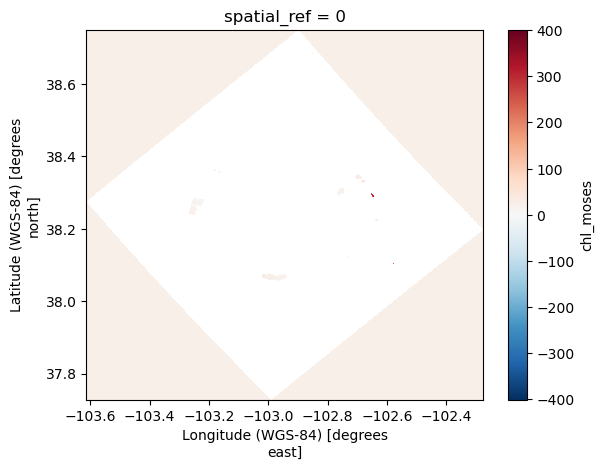

In [26]:
# Apply Water Quality Algorithms
ds_aqua['chl_moses'] = chlor_a(ds_aqua)
ds_aqua.chl_moses.where(ds_aqua.land_mask == 1).plot()

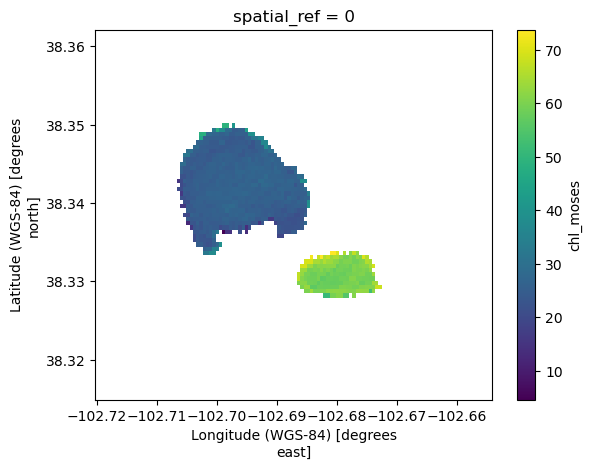

In [25]:
# Crop for Neenoshe Reservoir
N = 38.362006
W = -102.720106
S = 38.314948
E = -102.654359

ds_nee = ds_aqua.sel(longitude=slice(W, E), latitude=slice(N, S))
ds_nee.chl_moses.where(ds_nee.land_mask ==1).plot()

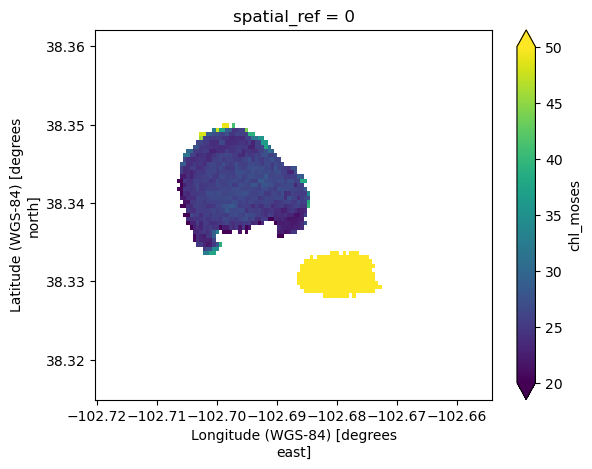

In [28]:
ds_nee.chl_moses.where(ds_nee.land_mask ==1).plot(vmin=20, vmax=50)

### Exercises

1. You can vary the colorbar range by adjusting vmin and vmax. When you adjust the ranges, what are the differences that occur between the two waterbodies? 

2. What aquatic processes could contribute to the large chlorophyll range (e.g., phytoplankton bloom, other types of aquatic biomass present?) 
